Preliminary data exploration

In [221]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import dmba
from pathlib import Path
import functools as ft
import string
import re
import spacy
import scikitplot as skplt
import plotly.graph_objs as go

from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from plotly.offline import init_notebook_mode, plot, iplot
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

from dmba import regressionSummary
from dmba import adjusted_r2_score, AIC_score, BIC_score
from dmba import backward_elimination, forward_selection, stepwise_selection

from dmba import plotDecisionTree, classificationSummary, regressionSummary
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity

from surprise import Dataset
from surprise import Reader
from surprise import KNNBasic

from dmba import gainsChart, liftChart
from ast import literal_eval

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [489]:
keywords_df = pd.read_csv('keywords.csv')
links_df = pd.read_csv('links.csv')
credits_df = pd.read_csv('credits.csv')
movie_meta_df = pd.read_csv('movies_metadata.csv')
movie_meta_df.sample(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
45265,False,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,265189,tt2121382,sv,Turist,"While holidaying in the French Alps, a Swedish...",...,2014-08-15,1359497.0,118.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,NaN,Force Majeure,False,6.8,255.0
33626,False,NaN,0,[],http://rebootfilm.com,143602,tt2090594,en,Reboot,Set within a dystopian world that is a collisi...,...,2012-12-12,0.0,40.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Your world is about to be reset.,Reboot,False,4.5,2.0
8686,False,NaN,0,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,122677,tt0068291,en,Blood of Ghastly Horror,A mad scientist implants an electronic device ...,...,1972-01-21,0.0,85.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Human zombies rise from their coffins as livin...,Blood of Ghastly Horror,False,1.5,4.0
28094,False,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 14, 'nam...",NaN,65131,tt0217841,ru,Ten',Musical tale about a struggle between a good S...,...,1971-09-18,0.0,87.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Shadow,False,6.4,4.0
1892,False,"{'id': 945, 'name': 'Lethal Weapon Collection'...",25000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,942,tt0097733,en,Lethal Weapon 2,"In the opening chase, Martin Riggs and Roger M...",...,1989-07-07,227853986.0,114.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,The magic is back!,Lethal Weapon 2,False,6.7,1066.0


In [508]:
ratings_df = pd.read_csv('ratings.csv')

In [525]:
ratings_small_df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


*EDA:*

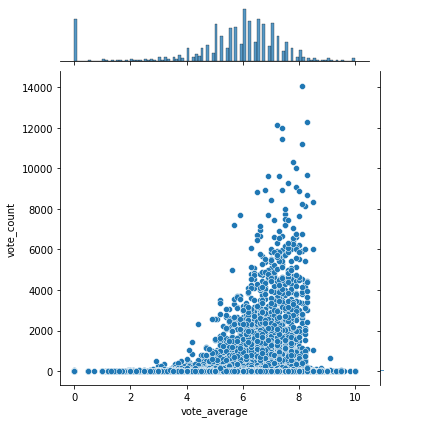

In [332]:
sns.jointplot(x='vote_average',y='vote_count', data=movie_meta_df)

In [529]:
# plot the rating avg vs rating count
# for our rating data:

ratings['rating_avg'] = pd.DataFrame(ratings_df.groupby('movieId')['rating'].mean())


ratings['rating_count'] = ratings_df.groupby('movieId')['rating'].count()
ratings.head()

,rating,number_of_ratings,rating_avg,rating_count
movieId,,,,
1,3.888157,66008,3.888157,66008
2,3.236953,26060,3.236953,26060
3,3.175550,15497,3.175550,15497
4,2.875713,2981,2.875713,2981
5,3.079565,15258,3.079565,15258


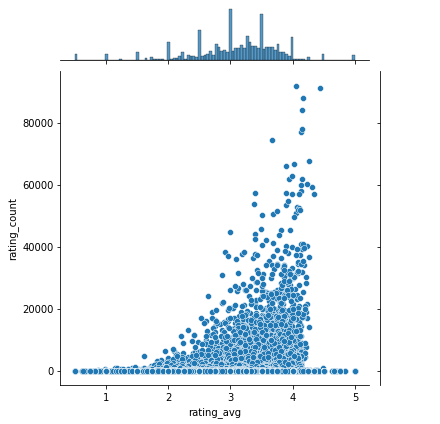

In [530]:
sns.jointplot(x='rating_avg', y='rating_count', data=ratings)

In [558]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go

#init_notebook_mode(connected=True)

data = ratings_small_df['rating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / ratings_small_df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution of Movie Ratings'.format(ratings_small_df.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [563]:
# Number of ratings per book
data = ratings_small_df.groupby('movieId')['rating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Movie (Clipped at 50)',
                   xaxis = dict(title = 'Number of Ratings Per Movie'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [671]:
rating_count = ratings_small_df.groupby('movieId')['rating'].count().reset_index()
rating_count_top10=rating_count.sort_values('rating', ascending=False)[:10]

In [672]:
rating_count_top10

,movieId,rating
321,356,341
266,296,324
284,318,311
525,593,304
232,260,291
427,480,274
2062,2571,259
0,1,247
472,527,244
522,589,237


In [683]:
# Correlate movieId from ratings dataset
# to the imdbId in the links dataset:

top10=[]
top10_movieId=rating_count_top10['movieId'].reset_index()

for s in range(0,len(rating_count_top10)):
    index_links_top10=links_df['movieId']==top10_movieId['movieId'][s]

    top10_imdb=links_df['imdbId'][index_links_top10].astype('string')
#    top10_imdb_string=top10_imdb.values[0]
#    top10_imdb_movie= [f"tt0{top10_imdb_string}"]
    top10.append(top10_imdb.values[0])


# Find the movie title related to the
# newfound imdbId in the movie_meta_df
# dataset and add it to the top 10 rated
# movie titles:

top10_titles=[]

for i in range(0,len(top10)):
    
    index_movie_top10=movie_meta_df.loc[movie_meta_df['imdb_id'].str.contains(top10[i], case=False)].index

    top10_title=movie_meta_df['title'][index_movie_top10]
    top10_title_string=top10_title.values[0]
    top10_titles.append(top10_title_string)

rating_count_top10['movie_title']=top10_titles



In [684]:
rating_count_top10

,movieId,rating,movie_title
321,356,341,Forrest Gump
266,296,324,Pulp Fiction
284,318,311,The Shawshank Redemption
525,593,304,The Silence of the Lambs
232,260,291,Star Wars
427,480,274,Jurassic Park
2062,2571,259,The Matrix
0,1,247,Toy Story
472,527,244,Schindler's List
522,589,237,Terminator 2: Judgment Day


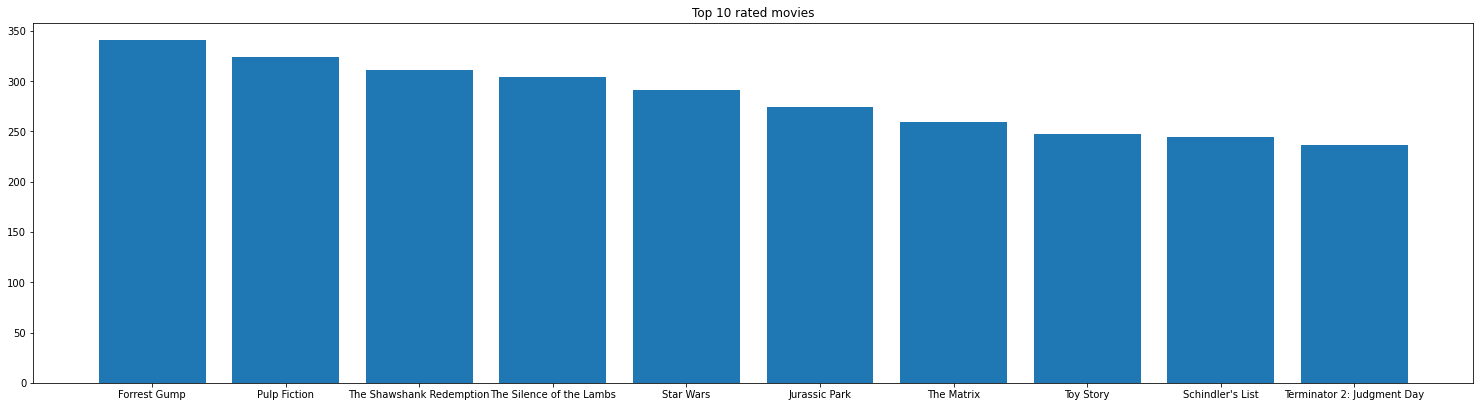

In [699]:

fig = plt.figure(figsize=(20,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(rating_count_top10['movie_title'],rating_count_top10['rating'])
plt.title('Top 10 rated movies')
plt.show()

*Association Rules:*

In [701]:
#Loading neccesary packages
import numpy as np
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [ ]:
# find what genres may have close association:



In [533]:
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity

from surprise import Dataset
from surprise import Reader
from surprise import KNNBasic


In [535]:
#ratings_df=ratings_df.drop(columns='timestamp')

In [702]:
ratings_small_df.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [541]:
#ratings_small_df=ratings_small_df.drop(columns='timestamp')

In [537]:
movie_mod=movie_meta_df[['movieId','vote_average']]

In [708]:
ratings_small_df['movieId']=ratings_small_df['movieId'].astype('category')
ratings_small_df['userId']=ratings_small_df['userId'].astype('category')

In [744]:
reader = Reader(rating_scale=(0, 6))
data = Dataset.load_from_df(ratings_small_df, reader)
trainset = data.build_full_trainset()

# compute cosine similarities between items
sim_options = {'name': 'cosine', 'user_based': False}  
algo = KNNBasic(sim_options=sim_options)
algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [739]:
movies = links_df.movieId
movies

0             1
1             2
2             3
3             4
4             5
          ...  
45838    176269
45839    176271
45840    176273
45841    176275
45842    176279
Name: movieId, Length: 45843, dtype: int64

In [748]:
movies = links_df.movieId
predictions2=pd.DataFrame(columns = ['user','new_movie','predicted_rating'])

for mov in movies: 
    #print(movies, algo.predict(1, movies).est >=4)
    predicted2 = algo.predict(2, mov).est 
    if predicted2 >= 4:
        highest_rated_index2 = predicted2
        print(mov, predicted2)
        predictions2.loc[len(predictions2.index)] = ['2', mov, predicted2] 
        #predictions2.append(mov)

        #highest_rated1=movies[highest_rated_index1]
predictions2.sort_values('predicted_rating', ascending=False)[:4]
#predicted_rec=movies[predictions]
#print(highest_rated1)

84 4.0
439 5.0
559 4.0
573 4.0
681 4.0
690 4.0
721 4.0
760 4.0
793 4.0
820 4.0
845 4.0
854 4.0
872 4.0
1040 4.0
1174 4.0
1328 5.0
1444 4.0
1472 4.0
1636 5.0
1733 4.0
2246 4.111111111111111
2562 4.0
3349 4.0
3454 4.5
3474 4.0
3628 4.0
3637 4.0
3766 4.077038156072072
3768 4.0
3780 4.0
3829 4.0
3879 4.0
3885 4.0
4045 4.0
4181 5.0
4466 4.0
4470 4.0
4475 4.25
4521 4.0
4527 5.0
4550 5.0
4559 5.0
4578 5.0
4945 4.0
5422 5.0
5605 4.0
5788 4.0
5834 5.0
5910 4.0
5917 4.0
5958 4.0
5969 5.0
6012 4.0
6014 4.0
6154 4.0
6332 4.5
6509 4.0
7051 4.0
7086 4.0
7172 4.0
7340 4.166666666666667
7453 4.5
7564 4.0
7574 4.0
7773 5.0
7786 4.0
7820 4.0
7919 4.0
8484 4.0
8485 4.0
8629 4.0
8642 4.5
8765 4.0
8982 4.0
25763 4.0
26150 4.0
26228 4.0
26265 4.0
26578 4.0
26903 4.0
27251 5.0
31524 4.0
31930 4.0
32456 4.0
33158 4.0
33296 4.5
37475 4.0
39408 5.0
39416 5.0
40491 4.0
43899 4.0
44225 4.5
44731 5.0
45000 4.0
45969 4.0
47122 4.5
50954 4.2
51939 4.0
52528 4.0
52617 4.0
54734 4.5
54780 4.0
55100 4.5
58425 4.0
58655

,user,new_movie,predicted_rating
80,2,27251,5.0
15,2,1328,5.0
88,2,39416,5.0
87,2,39408,5.0


In [753]:
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [759]:
top4_movieId


,index,new_movie
0,80,27251
1,15,1328
2,88,39416
3,87,39408


*Movie titles added to top 4 recommended for user 2:*

In [751]:
top4_predictions_user2 = predictions2.sort_values('predicted_rating', ascending=False)[:4]

In [760]:

top4_movieId=top4_predictions_user2['new_movie'].reset_index()
top4_titles=[]

for ee in range(0,len(top4_predictions_user2)):
    index_links_top4=links_df['movieId']==top4_movieId['new_movie'][ee]

    top4_imdb=links_df['imdbId'][index_links_top4].astype('string')
        
    top4=top4_imdb.values[0]

    index_movie_top4=movie_meta_df.loc[movie_meta_df['imdb_id'].str.contains(top4, case=False)].index

    top4_title=movie_meta_df['title'][index_movie_top4]
    top4_title_string=top4_title.values[0]
    top4_titles.append(top4_title_string)


top4_predictions_user2['movie_title']=top4_titles


In [761]:
top4_predictions_user2

,user,new_movie,predicted_rating,movie_title
80,2,27251,5.0,The 10th Kingdom
15,2,1328,5.0,The Amityville Curse
88,2,39416,5.0,Kids in America
87,2,39408,5.0,Left Behind III: World at War


*Automate:*

In [763]:
ratings_small_df['userId'].unique()

[1, 2, 3, 4, 5, ..., 667, 668, 669, 670, 671]
Length: 671
Categories (671, int64): [1, 2, 3, 4, ..., 668, 669, 670, 671]

In [795]:
predictions_user=pd.DataFrame(columns=['user','new_movie','predicted_rating'])
predictions_user

,user,new_movie,predicted_rating


In [796]:
# Automate:

movies = links_df.movieId
#predictions_user=pd.DataFrame(columns = ['user','new_movie','predicted_rating'])
predictions_all=pd.DataFrame()
#predictions_all.columns = ['user','new_movie','predicted_rating']

#print(movies, algo.predict(1, movies).est >=4)
    
for user in ratings_small_df['userId'].unique():
    # create temporary dataframe to store individual
    # predictions:
    #print("=================\n")
    #print(user)
    #print("=================\n")

    predictions_user=pd.DataFrame(columns=['user','new_movie','predicted_rating'])
                                 
    for mov in movies:
        predictedUSER = algo.predict(user, mov).est 
    
        if predictedUSER >= 4:
            highest_rated_indexUSER = predictedUSER
            #print(mov, predictedUSER)
            predictions_user.loc[len(predictions_user.index)] = [user, mov, predictedUSER] 
            #predictions2.append(mov)
            #predictions_user
            #highest_rated1=movies[highest_rated_index1]
    
    top_4_USER = predictions_user.sort_values('predicted_rating', ascending=False)[:4]
    #print(top_4_USER)
    #predictions_all.loc[len(predictions_all.index):len(predictions_all.index)+4] = top_4_USER
    predictions_all=pd.concat([predictions_all, top_4_USER], ignore_index=True, sort=False)
   # print(predictions_all)

predictions_all.columns = ['user','new_movie','predicted_rating']
    
#predicted_rec=movies[predictions]
#print(highest_rated1)

In [798]:
predictions_all.shape

(2650, 3)

In [802]:
predictions_user

,user,new_movie,predicted_rating
0,671.0,1.0,4.100628
1,671.0,7.0,4.011990
2,671.0,9.0,4.099485
3,671.0,10.0,4.012579
4,671.0,17.0,4.110051
...,...,...,...
3972,671.0,161918.0,4.087500
3973,671.0,161944.0,4.375000
3974,671.0,162542.0,4.500000
3975,671.0,162672.0,4.500000


In [801]:
predictions_all.tail()

,user,new_movie,predicted_rating
2645,670.0,4593.0,5.0
2646,671.0,134783.0,4.833333
2647,671.0,39416.0,4.833333
2648,671.0,5422.0,4.833333
2649,671.0,127124.0,4.833333


In [805]:
predictions_all.to_csv('Top4_MovieRecs.csv')

In [804]:
ratings_small_df['userId'].unique()

[1, 2, 3, 4, 5, ..., 667, 668, 669, 670, 671]
Length: 671
Categories (671, int64): [1, 2, 3, 4, ..., 668, 669, 670, 671]

In [ ]:
# do correlations matrix like in my notebook:

In [729]:
highest_rated_index1

False

*Experiments:*

In [358]:
#movie_titles=[]
#def lookup_movie_title(id):
#    match = (movie_meta_df['movieId'] == id)
#    movies = (movie_meta_df['original_title'][match])
#    movie_titles.append(movies.values[0])
#   return movie_title.values[0]


In [360]:
#ratings_df['movieId'].apply(lookup_movie_title)

In [381]:
id_ratings[0]

110

In [395]:
movie_meta_df['original_title'][302]

'Trois couleurs : Rouge'

In [517]:
id_ratings[0]

110

In [524]:
index=movie_meta_df['movieId']==id_ratings[0]
rating_110=pd.DataFrame(movie_meta_df['title'][index])
rating_110

,title


In [ ]:
# Testing
#id_ratings=ratings_small_df['movieId']
#humans=[]
#index=movie_meta_df['movieId']==id_ratings[0]
#rating_110=pd.DataFrame(movie_meta_df['title'][index])
##title_i_need=rating_110.values[0]
#humans.append(rating_110.values[0])

#index=movie_meta_df['movieId']==id_ratings[2]
#rating_110=pd.DataFrame(movie_meta_df['original_title'][index])
#title_i_need=rating_110.values[0]
#humans.append(rating_110.values[0])

#humans2=pd.DataFrame(humans)
#ham_pig=pd.DataFrame()

#ham_pig['weird']=humans2

#ham_pig.head()

In [ ]:
# attempt to join movie title to movie id 
# but too long. will use references from
# now on...

id_ratings=ratings_small_df['movieId']
titles_list=[]

for r in range(0,len(id_ratings)):

    index=links_df['movieId']==id_ratings[r]
    title=pd.DataFrame(links_id['imdbId'][index])
    if title.empty:
        titles_list.append('NA')
    else:
        titles_list.append(title.values[0])
        
        
movie_titles=pd.DataFrame(titles_list)
ratings_small_df['movie_title']=movie_titles


#movie_titles = movie_meta_df['original_title'][match]

In [223]:
ratings_df.shape

(26024289, 4)

In [528]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [608]:
movie_meta_df.rename(columns={'movieId':'id'}, inplace=True)

In [669]:
movie_meta_df['imdb_id']
movie_meta_df.loc[movie_meta_df['imdb_id'].str.contains("76759", case=False)]


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
256,False,"{'id': 10, 'name': 'Star Wars Collection', 'po...",11000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",http://www.starwars.com/films/star-wars-episod...,11,tt0076759,en,Star Wars,Princess Leia is captured and held hostage by ...,...,1977-05-25,775398007.0,121.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"A long time ago in a galaxy far, far away...",Star Wars,False,8.1,6778.0


In [353]:
credits_df.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [685]:
#top10_movieId=rating_count_top10['movieId']
#top10_movieId['movieId'][0]

#index_movie_top10=movie_meta_df['imdb_id']==top10_movie_imdb['movie_imdb'][4]
#movie_meta_df['title'][index_movie_top10].values[0]

In [680]:
movie_meta_df.loc[movie_meta_df['imdb_id'].str.contains(top10[0], case=False)]


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
351,False,NaN,55000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,13,tt0109830,en,Forrest Gump,A man with a low IQ has accomplished great thi...,...,1994-07-06,677945399.0,142.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"The world will never be the same, once you've ...",Forrest Gump,False,8.2,8147.0


In [665]:
index_links=links_df['movieId']==260
links_df[index_links]

,movieId,imdbId,tmdbId
257,260,76759,11.0


In [634]:
rating_count_top10

,movieId,rating
321,356,341
266,296,324
284,318,311
525,593,304
232,260,291
427,480,274
2062,2571,259
0,1,247
472,527,244
522,589,237


In [609]:
index_top_rated=ratings_small_df['movieId']==356
ratings_small_df[index_top_rated]

,userId,movieId,rating
57,2,356,3.0
103,3,356,5.0
159,4,356,5.0
359,5,356,4.0
516,7,356,3.0
...,...,...,...
98766,664,356,4.5
99302,665,356,4.0
99712,666,356,5.0
99772,667,356,4.0


In [610]:
index_links=links_df['movieId']==356
links_df[index_links]

,movieId,imdbId,tmdbId
352,356,109830,13.0


In [626]:
top_imdb_movie[0]

'tt0109830'

In [627]:
# Find top rated movie with movieId
# 356 but using the links_df dataset:

index_links=links_df['movieId']==356
top_imdb=links_df['imdbId'][index_links].astype('string')
top_imdb_string=top_imdb.values[0]
top_imdb_movie= [f"tt0{top_imdb_string}"]
top_imdb_movie
movie_meta_df['imdb_id']=movie_meta_df['imdb_id'].astype('string')

index_top_rated_movie = movie_meta_df['imdb_id']==top_imdb_movie[0]
title_top_rated_movie=pd.DataFrame(movie_meta_df['title'][index_top_rated_movie])
title_top_rated_movie.values[0]


array(['Forrest Gump'], dtype=object)

In [592]:
ratings_small_df[index_top]

,userId,movieId,rating
57,2,356,3.0
103,3,356,5.0
159,4,356,5.0
359,5,356,4.0
516,7,356,3.0
...,...,...,...
98766,664,356,4.5
99302,665,356,4.0
99712,666,356,5.0
99772,667,356,4.0


*process data:*

In [233]:
# drop vote average and vote count
#movie_meta_df=movie_meta_df.drop(columns=['vote_average', 'vote_count'])

In [234]:
#tags_df = pd.read_csv('tags.csv')
#tags_df.sample(5)

In [700]:
# dropping adult rated movies

filtered_rows = movie_meta_df[movie_meta_df['adult']=='True'].index
movie_meta_df = movie_meta_df.drop(index=filtered_rows)

# dropping adult column no longer needed
movie_meta_df = movie_meta_df.drop(columns='adult')

In [339]:
# dropping movies that are not already Released
filtered_rows = movie_meta_df[movie_meta_df['status']!='Released'].index
movie_meta_df = movie_meta_df.drop(index=filtered_rows)

# dropping status column no longer needed with unreleased movies excluded
movie_meta_df = movie_meta_df.drop(columns='status')

In [340]:
# dropping movies that are not already Released
filtered_rows = movie_meta_df[movie_meta_df['video']==True].index
movie_meta_df = movie_meta_df.drop(index=filtered_rows)
# dropping video column no longer needed
movie_meta_df = movie_meta_df.drop(columns='video')

In [450]:
movie_meta_df.head()

,belongs_to_collection,budget,genres,homepage,movieId,imdb_id,original_language,original_title,overview,popularity,...,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,title,vote_average,vote_count
0,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,...,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",NaN,Toy Story,7.7,5415.0
1,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,...,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Roll the dice and unleash the excitement!,Jumanji,6.9,2413.0
2,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,...,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,92.0
3,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,...,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Friends are the people who let you be yourself...,Waiting to Exhale,6.1,34.0
4,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,...,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,5.7,173.0


*combine datasets:*

In [342]:


movie_meta_df['id']=movie_meta_df['id'].astype(int)
credits_df['id']=credits_df['id'].astype(int)
keywords_df['id']=keywords_df['id'].astype(int)


movies = pd.merge(movie_meta_df,credits_df, on='id', how='left')
movies = pd.merge(movies,keywords_df, on='id', how='left')


movies.head()

,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,...,revenue,runtime,spoken_languages,tagline,title,vote_average,vote_count,cast,crew,keywords
0,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,...,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",NaN,Toy Story,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,...,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Roll the dice and unleash the excitement!,Jumanji,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,...,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,92.0,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,...,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Friends are the people who let you be yourself...,Waiting to Exhale,6.1,34.0,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,...,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,5.7,173.0,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [346]:
links_df['id'] = links_df['tmdbId']
movies = pd.merge(movies,links_df, on='id', how='left')

In [240]:
#ratings_df.drop(columns=['userId', 'timestamp'], inplace=True)
#ratings_df.head()

,movieId,rating
0,110,1.0
1,147,4.5
2,858,5.0
3,1221,5.0
4,1246,5.0


In [241]:
avg_ratings = round(ratings_df.groupby('movieId').mean(),2)

In [242]:
movies = pd.merge(movies,avg_ratings, on='movieId', how='left')

movies.head()

,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,...,spoken_languages,tagline,title,cast,crew,keywords,movieId,imdbId,tmdbId,rating
0,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,...,"[{'iso_639_1': 'en', 'name': 'English'}]",NaN,Toy Story,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",1,114709,862.0,3.89
1,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Roll the dice and unleash the excitement!,Jumanji,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1...",2,113497,8844.0,3.24
2,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392...",3,113228,15602.0,3.18
3,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Friends are the people who let you be yourself...,Waiting to Exhale,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':...",4,114885,31357.0,2.88
4,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...",5,113041,11862.0,3.08


*Extract JSON features:*

In [243]:
features = ['cast', 'crew', 'genres', 'keywords']

movies = movies.dropna(subset=features)

for feature in features:
    movies[feature] = movies[feature].apply(literal_eval)

In [244]:
## function to get name of director from the crew field
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

# get director
movies['director'] = movies['crew'].apply(get_director)
movies = movies.drop(columns='crew')

In [245]:
# Returns the list of top 3 elements for genres and keywords
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [246]:
features = ['cast', 'keywords', 'genres']

for feature in features:
    movies[feature] = movies[feature].apply(get_list)

In [247]:
movies = movies.drop(columns=['belongs_to_collection', # this looks like an id column to me so not necessary to add
                     'homepage', # weblink so not needed
                     'id', # simple ID column not helpful for predicting
                     'imdb_id', # again an ID column
                     'original_title', # just a name
                     'overview', # we already have the top keywords as a column
                     'poster_path', # 
                     'production_companies', # 
                     'production_countries', #
                     'spoken_languages', # we have original language as a column - high correlation
                     'tagline', # we have keywords
#                     'title', # just a name    
                     'movieId' , 'imdbId', 'tmdbId']) # just more IDs  

In [248]:
movies = movies.dropna()
movies.isnull().sum()

budget               0
genres               0
original_language    0
popularity           0
release_date         0
revenue              0
runtime              0
cast                 0
keywords             0
rating               0
director             0
dtype: int64

*Encode:*

In [286]:
genres_cat = movies.genres.str.join('|').str.get_dummies().add_prefix('genres_')

In [287]:
movies = pd.concat([movies, genres_cat], axis = 1)

In [288]:
movies['Release_Year'] = movies['release_date'].str[:4]
movies['Release_Month'] = movies['release_date'].str[5:7]

In [289]:
movies = pd.get_dummies(movies, columns=['Release_Year', 'Release_Month', 'original_language'])
movies

,budget,genres,popularity,release_date,revenue,runtime,cast,keywords,rating,director,...,original_language_tl,original_language_tr,original_language_uk,original_language_ur,original_language_uz,original_language_vi,original_language_wo,original_language_xx,original_language_zh,original_language_zu
0,30000000,"[Animation, Comedy, Family]",21.946943,1995-10-30,373554033.0,81.0,"[Tom Hanks, Tim Allen, Don Rickles]","[jealousy, toy, boy]",3.89,John Lasseter,...,0,0,0,0,0,0,0,0,0,0
1,65000000,"[Adventure, Fantasy, Family]",17.015539,1995-12-15,262797249.0,104.0,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]","[board game, disappearance, based on children'...",3.24,Joe Johnston,...,0,0,0,0,0,0,0,0,0,0
2,0,"[Romance, Comedy]",11.7129,1995-12-22,0.0,101.0,"[Walter Matthau, Jack Lemmon, Ann-Margret]","[fishing, best friend, duringcreditsstinger]",3.18,Howard Deutch,...,0,0,0,0,0,0,0,0,0,0
3,16000000,"[Comedy, Drama, Romance]",3.859495,1995-12-22,81452156.0,127.0,"[Whitney Houston, Angela Bassett, Loretta Devine]","[based on novel, interracial relationship, sin...",2.88,Forest Whitaker,...,0,0,0,0,0,0,0,0,0,0
4,0,[Comedy],8.387519,1995-02-10,76578911.0,106.0,"[Steve Martin, Diane Keaton, Martin Short]","[baby, midlife crisis, confidence]",3.08,Charles Shyer,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46329,0,[Science Fiction],0.661558,1995-01-01,0.0,85.0,"[Lisa Boyle, Kena Land, Zaneta Polard]",[],2.00,Aaron Osborne,...,0,0,0,0,0,0,0,0,0,0
46330,0,"[Drama, Action, Romance]",5.683753,1991-05-13,0.0,104.0,"[Patrick Bergin, Uma Thurman, David Morrissey]",[],4.00,John Irvin,...,0,0,0,0,0,0,0,0,0,0
46332,0,[Drama],0.178241,2011-11-17,0.0,360.0,"[Angel Aquino, Perry Dizon, Hazel Orencio]","[artist, play, pinoy]",5.00,Lav Diaz,...,1,0,0,0,0,0,0,0,0,0
46333,0,"[Action, Drama, Thriller]",0.903007,2003-08-01,0.0,90.0,"[Erika Eleniak, Adam Baldwin, Julie du Page]",[],1.00,Mark L. Lester,...,0,0,0,0,0,0,0,0,0,0


In [290]:
## remove variables that are not needed after encoding

movies = movies.drop(columns=['genres', 'release_date', 'cast', 'keywords', 'director'])

*Train/Test Split:*

In [291]:
trainData, testData = train_test_split(movies, test_size=0.2, random_state=1)

In [292]:
trainData.reset_index(drop=True, inplace=True)
testData.reset_index(drop=True, inplace=True)

In [293]:
print(trainData.shape)
print(testData.shape)

(35614, 259)
(8904, 259)


In [294]:
scaler = MinMaxScaler()

to_be_scaled = ['budget', 'popularity', 'revenue', 'runtime']

In [295]:
# training scaler ONLY on training data

train_scaled = scaler.fit_transform(trainData[to_be_scaled])

train_scaled = pd.DataFrame(train_scaled)

train_scaled.columns = to_be_scaled

# add scaled data back to dataframe
trainData = trainData.drop(columns=to_be_scaled)
trainData = pd.concat([trainData, train_scaled], axis = 1)

trainData.head()

,rating,genres_Action,genres_Adventure,genres_Animation,genres_Comedy,genres_Crime,genres_Documentary,genres_Drama,genres_Family,genres_Fantasy,...,original_language_uz,original_language_vi,original_language_wo,original_language_xx,original_language_zh,original_language_zu,budget,popularity,revenue,runtime
0,2.50,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0.000000,0.000004,0.0,0.064490
1,0.50,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,0.000002,0.0,0.079618
2,2.00,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,0.000208,0.0,0.075637
3,3.25,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000053,0.001045,0.0,0.027866
4,3.17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,0.002123,0.0,0.000000


In [296]:
# fitting scaler on test data

test_scaled = scaler.transform(testData[to_be_scaled])

test_scaled = pd.DataFrame(test_scaled)

test_scaled.columns = to_be_scaled

# add scaled data back to dataframe
testData = testData.drop(columns=to_be_scaled)
testData = pd.concat([testData, test_scaled], axis = 1)

testData.head()

,rating,genres_Action,genres_Adventure,genres_Animation,genres_Comedy,genres_Crime,genres_Documentary,genres_Drama,genres_Family,genres_Fantasy,...,original_language_uz,original_language_vi,original_language_wo,original_language_xx,original_language_zh,original_language_zu,budget,popularity,revenue,runtime
0,2.75,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0.0,0.000992,0.0,0.076433
1,3.40,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0.0,0.001789,0.0,0.071656
2,3.50,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0.0,0.001147,0.0,0.091561
3,2.42,1,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0.0,0.004349,0.0,0.121019
4,4.50,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.011693,0.0,0.075637


*Model:*

In [310]:
#trainY =  round(trainData[['rating']],0)
#testY = round(testData[['rating']],0)

trainY =  trainData[['rating']]
testY = testData[['rating']]

trainX = trainData.drop(columns=['rating'])
testX = testData.drop(columns=['rating'])

In [309]:
trainX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35614 entries, 0 to 35613
Columns: 258 entries, genres_Action to runtime
dtypes: float64(4), int64(20), uint8(234)
memory usage: 14.5 MB


In [311]:
#Regression:

Trainy=trainY
Validy=testY

In [298]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
enc.fit(trainY)
Trainy=pd.DataFrame(enc.transform(trainY))
Validy=pd.DataFrame(enc.transform(testY))

In [305]:
Trainy.value_counts()

3.0    17272
4.0    10726
2.0     6279
1.0      720
0.0      342
5.0      275
dtype: int64

In [299]:
Trainy=Trainy.astype('category')
Validy=Validy.astype('category')


In [300]:
# partition the data 
#train_X_mov, valid_mov, train_y_mov, valid_y_mov = train_test_split(X_movies_dummies, 
#                                                          y_movies, 
#                                                          test_size=0.4, 
#                                                          random_state=1)

In [301]:
Tree_movies_team = DecisionTreeClassifier(max_depth=8)
Tree_movies_team.fit(trainX, Trainy)

DecisionTreeClassifier(max_depth=8)

In [312]:
# Regression:

Tree_movies_teamR = DecisionTreeRegressor(max_depth=8)
Tree_movies_teamR.fit(trainX, Trainy)

DecisionTreeRegressor(max_depth=8)

In [317]:
# Regression:

regressionSummary(Trainy, Tree_movies_teamR.predict(trainX))


Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 0.6480
            Mean Absolute Error (MAE) : 0.4748
          Mean Percentage Error (MPE) : -9.3637
Mean Absolute Percentage Error (MAPE) : 22.2648


In [318]:
regressionSummary(Validy, Tree_movies_teamR.predict(testX))


Regression statistics

                      Mean Error (ME) : 0.0092
       Root Mean Squared Error (RMSE) : 0.6691
            Mean Absolute Error (MAE) : 0.4914
          Mean Percentage Error (MPE) : -9.2192
Mean Absolute Percentage Error (MAPE) : 22.7192


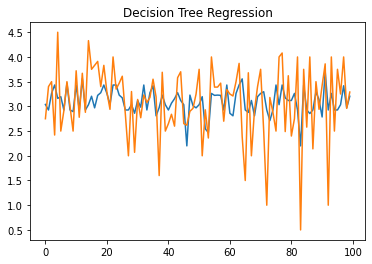

In [330]:
predict_R=pd.DataFrame(Tree_movies_teamR.predict(testX))
plt.figure()
plt.plot(predict_R.iloc[0:100])
plt.plot(Validy.iloc[0:100])

#plt.plot(Validy)
#plt.plot(X_test, y_1, color="cornflowerblue", label="max_depth=2", linewidth=2)
#plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
#plt.xlabel("data")
#plt.ylabel("target")
plt.title("Decision Tree Regression")
#plt.legend()
plt.show()

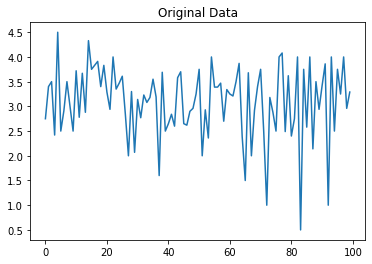

In [326]:
plt.figure()
#plt.plot(Tree_movies_teamR.predict(testX))
plt.plot(Validy.iloc[0:100])
#plt.plot(X_test, y_1, color="cornflowerblue", label="max_depth=2", linewidth=2)
#plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
#plt.xlabel("data")
#plt.ylabel("target")
plt.title("Original Data")
#plt.legend()
plt.show()

In [302]:
classificationSummary(Trainy, Tree_movies_team.predict(trainX))

Confusion Matrix (Accuracy 0.5386)

       Prediction
Actual     0     1     2     3     4     5
     0     1     0    70   241    30     0
     1     0    14   215   454    37     0
     2     0     1  1176  4683   419     0
     3     0     0   738 14520  2014     0
     4     0     1   213  7042  3470     0
     5     0     1    17   208    49     0


In [304]:
classificationSummary(Validy, Tree_movies_team.predict(testX))

Confusion Matrix (Accuracy 0.5201)

       Prediction
Actual    0    1    2    3    4    5
     0    0    0   25   58    6    0
     1    0    0   46  105   11    0
     2    0    5  257 1204  107    0
     3    0    1  194 3567  534    0
     4    0    0   60 1829  807    0
     5    0    0    7   67   14    0


parse dataset movies_df:

In [90]:
movies_df.shape

(45466, 24)

In [171]:
movies_df.isna().sum()

Te                          0
Ta                          0
Afrikaans                   0
Italian                     0
Japanese                    0
French                      0
English                     0
Horror_genre                0
Romance_genre               0
Animation_genre             0
Family_genre                0
Drama_genre                 0
Thriller_genre              0
Documentary_genre           0
Action_genre                0
Crime_genre                 0
War_genre                   0
Comedy_genre                0
adult                       0
budget                      0
genres                      0
id                          0
original_language          11
original_title              0
overview                  685
popularity                  0
production_companies        0
production_countries        0
release_date               72
revenue                     0
runtime                     0
spoken_languages            0
status                      0
tagline   

In [165]:
#movies_df=movies_df.copy()
movies_df=movies_df.drop(columns=['poster_path',
                                  'homepage',
                                  'belongs_to_collection',
                                  'imdb_id'])


In [166]:
# Remove the 6 records missing voting stats and revenue/language:

movies_df=movies_df.dropna(subset=['vote_average'])
movies_df=movies_df.dropna(subset=['status'])
movies_df=movies_df.dropna(subset=['runtime'])

In [93]:
movies_df['genres'].value_counts()

[{'id': 18, 'name': 'Drama'}]                                                                                                         5000
[{'id': 35, 'name': 'Comedy'}]                                                                                                        3621
[{'id': 99, 'name': 'Documentary'}]                                                                                                   2723
[]                                                                                                                                    2442
[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]                                                                       1301
                                                                                                                                      ... 
[{'id': 28, 'name': 'Action'}, {'id': 18, 'name': 'Drama'}, {'id': 35, 'name': 'Comedy'}, {'id': 99, 'name': 'Documentary'}]             1
[{'id': 10752, 'name': 'War

In [168]:
# Comedy, War, Action, Crime, History, 
# Documentary, Thriller, Drama,
# Family, Animation, Romance, Horror,


# Find rows with different genres and generate
# columns based on these features:

import re

ids = movies_df.genres.str.contains('Comedy', flags = re.IGNORECASE, regex = True, na = False)
movies_df.insert(0,'Comedy_genre',0)
movies_df['Comedy_genre'].iloc[ids] = 1

ids_war = movies_df.genres.str.contains('War', flags = re.IGNORECASE, regex = True, na = False)
movies_df.insert(0,'War_genre',0)
movies_df['War_genre'].iloc[ids_war] = 1

ids_crime = movies_df.genres.str.contains('Crime', flags = re.IGNORECASE, regex = True, na = False)
movies_df.insert(0,'Crime_genre',0)
movies_df['Crime_genre'].iloc[ids_crime] = 1

ids_action = movies_df.genres.str.contains('Action', flags = re.IGNORECASE, regex = True, na = False)
movies_df.insert(0,'Action_genre',0)
movies_df['Action_genre'].iloc[ids_action] = 1

ids_documentary = movies_df.genres.str.contains('Documentary', flags = re.IGNORECASE, regex = True, na = False)
movies_df.insert(0,'Documentary_genre',0)
movies_df['Documentary_genre'].iloc[ids_documentary] = 1

ids_thriller = movies_df.genres.str.contains('Thriller', flags = re.IGNORECASE, regex = True, na = False)
movies_df.insert(0,'Thriller_genre',0)
movies_df['Thriller_genre'].iloc[ids_thriller] = 1

ids_drama = movies_df.genres.str.contains('Drama', flags = re.IGNORECASE, regex = True, na = False)
movies_df.insert(0,'Drama_genre',0)
movies_df['Drama_genre'].iloc[ids_drama] = 1

ids_family = movies_df.genres.str.contains('Family', flags = re.IGNORECASE, regex = True, na = False)
movies_df.insert(0,'Family_genre',0)
movies_df['Family_genre'].iloc[ids_family] = 1

ids_animation = movies_df.genres.str.contains('Animation', flags = re.IGNORECASE, regex = True, na = False)
movies_df.insert(0,'Animation_genre',0)
movies_df['Animation_genre'].iloc[ids_animation] = 1

ids_romance = movies_df.genres.str.contains('Romance', flags = re.IGNORECASE, regex = True, na = False)
movies_df.insert(0,'Romance_genre',0)
movies_df['Romance_genre'].iloc[ids_romance] = 1

ids_horror = movies_df.genres.str.contains('Horror', flags = re.IGNORECASE, regex = True, na = False)
movies_df.insert(0,'Horror_genre',0)
movies_df['Horror_genre'].iloc[ids_horror] = 1


In [136]:
movies_df_final['spoken_languages'].value_counts()

[{'iso_639_1': 'en', 'name': 'English'}]                                                                                      22369
[]                                                                                                                             3680
[{'iso_639_1': 'fr', 'name': 'Français'}]                                                                                      1836
[{'iso_639_1': 'ja', 'name': '日本語'}]                                                                                           1288
[{'iso_639_1': 'it', 'name': 'Italiano'}]                                                                                      1192
                                                                                                                              ...  
[{'iso_639_1': 'bs', 'name': 'Bosanski'}, {'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'it', 'name': 'Italiano'}]        1
[{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'ta', 'name': 'தமிழ்'

In [169]:

# Find rows with different languages spoken and generate
# columns based on these features:

ids_english = movies_df.spoken_languages.str.contains('English', flags = re.IGNORECASE, regex = True, na = False)
movies_df.insert(0,'English',0)
movies_df['English'].iloc[ids_english] = 1

ids_french = movies_df.spoken_languages.str.contains('Français', flags = re.IGNORECASE, regex = True, na = False)
movies_df.insert(0,'French',0)
movies_df['French'].iloc[ids_french] = 1

ids_japanese = movies_df.spoken_languages.str.contains('日本語', flags = re.IGNORECASE, regex = True, na = False)
movies_df.insert(0,'Japanese',0)
movies_df['Japanese'].iloc[ids_japanese] = 1

ids_italian = movies_df.spoken_languages.str.contains('Italiano', flags = re.IGNORECASE, regex = True, na = False)
movies_df.insert(0,'Italian',0)
movies_df['Italian'].iloc[ids_italian] = 1

ids_afrikaans = movies_df.spoken_languages.str.contains('Afrikaans', flags = re.IGNORECASE, regex = True, na = False)
movies_df.insert(0,'Afrikaans',0)
movies_df['Afrikaans'].iloc[ids_afrikaans] = 1

ids_ta = movies_df.spoken_languages.str.contains('தமிழ்', flags = re.IGNORECASE, regex = True, na = False)
movies_df.insert(0,'Ta',0)
movies_df['Ta'].iloc[ids_ta] = 1

ids_te = movies_df.spoken_languages.str.contains('తెలుగు', flags = re.IGNORECASE, regex = True, na = False)
movies_df.insert(0,'Te',0)
movies_df['Te'].iloc[ids_te] = 1

In [170]:
movies_df.reset_index(inplace=True, drop=True)

In [172]:
# Separate the release year from the 
# Release date:

yearreleased=[]

def conv_YearRelease(x):
    if pd.isnull(x): 
      # if there are nulls, exit out and return the null value
        return x
    
    sptreld = x.split('-') 
    yearreleased.append(sptreld[0]) 

    return yearreleased

In [173]:
movies_df['release_date'].apply(conv_YearRelease)
Year_Release=pd.DataFrame(yearreleased,columns=['Year_Released'])
movies_df=movies_df.join(Year_Release)

In [142]:
movies_df['release_date'].head()

0    1995-10-30
1    1995-12-15
2    1995-12-22
3    1995-12-22
4    1995-02-10
Name: release_date, dtype: object

In [131]:
movies_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,Year_Released
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995


In [174]:
movies_df.isna().sum()

Te                          0
Ta                          0
Afrikaans                   0
Italian                     0
Japanese                    0
French                      0
English                     0
Horror_genre                0
Romance_genre               0
Animation_genre             0
Family_genre                0
Drama_genre                 0
Thriller_genre              0
Documentary_genre           0
Action_genre                0
Crime_genre                 0
War_genre                   0
Comedy_genre                0
adult                       0
budget                      0
genres                      0
id                          0
original_language          11
original_title              0
overview                  685
popularity                  0
production_companies        0
production_countries        0
release_date               72
revenue                     0
runtime                     0
spoken_languages            0
status                      0
tagline   

In [207]:
movies_df[['vote_average']]=round(movies_df[['vote_average']],0)

In [209]:
movies_df[['vote_averge']]=movies_df[['vote_average']].astype('category')

In [210]:
movies_df[['revenue','budget','runtime','popularity']] = movies_df[['revenue','budget','runtime','popularity']].astype(float)


In [93]:
movies_df['genres'].value_counts()

[{'id': 18, 'name': 'Drama'}]                                                                                                         5000
[{'id': 35, 'name': 'Comedy'}]                                                                                                        3621
[{'id': 99, 'name': 'Documentary'}]                                                                                                   2723
[]                                                                                                                                    2442
[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]                                                                       1301
                                                                                                                                      ... 
[{'id': 28, 'name': 'Action'}, {'id': 18, 'name': 'Drama'}, {'id': 35, 'name': 'Comedy'}, {'id': 99, 'name': 'Documentary'}]             1
[{'id': 10752, 'name': 'War

In [211]:
X_movies = movies_df.drop(columns=['overview','tagline','original_language',
                                  'original_title','production_companies',
                                  'production_countries','genres',
                                  'id','spoken_languages','title',
                                  'release_date'])
X_movies = X_movies.dropna()

In [212]:
y_movies=X_movies[['vote_average']]
X_movies=X_movies.drop(columns=['vote_average','vote_count'])

X_movies_dummies=pd.get_dummies(X_movies,drop_first=True)

In [213]:
X_movies_dummies.head()

,Te,Ta,Afrikaans,Italian,Japanese,French,English,Horror_genre,Romance_genre,Animation_genre,...,vote_averge_1.0,vote_averge_2.0,vote_averge_3.0,vote_averge_4.0,vote_averge_5.0,vote_averge_6.0,vote_averge_7.0,vote_averge_8.0,vote_averge_9.0,vote_averge_10.0
0,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [214]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
enc.fit(y_movies)


OrdinalEncoder()

In [215]:
# partition the data 
train_X_mov, valid_mov, train_y_mov, valid_y_mov = train_test_split(X_movies_dummies, 
                                                          y_movies, 
                                                          test_size=0.4, 
                                                          random_state=1)

In [216]:
Tree_movies = DecisionTreeClassifier(max_depth=8)
Tree_movies.fit(train_X_mov, train_y_mov)

DecisionTreeClassifier(max_depth=8)

In [218]:
classificationSummary(train_y_mov, Tree_movies.predict(train_X_mov))

Confusion Matrix (Accuracy 0.9925)

       Prediction
Actual    0    1    2    3    4    5    6    7    8    9   10
     0 1815    0    0    0    0    0    0    0    0    0    0
     1   76    0    0    0    0    0    0    0    0    0    0
     2    0    0  249    0    0    0    0    0    0    0    0
     3    0    0    0  493    0    0    0    0    0    0    0
     4    0    0    0    0 2055    0    0    0    0    0    0
     5    0    0    0    0    0 4404    0    0    0    0    0
     6    0    0    0    0    0    0 9285    0    0    0    0
     7    0    0    0    0    0    0    0 6031    0    0    0
     8    0    0    0    0    0    0    0    0 2326    0    0
     9    0    0    0    0    0    0    0    0    0  170    0
    10  128    0    0    0    0    0    0    0    0    0    0


In [219]:
classificationSummary(valid_y_mov, Tree_movies.predict(valid_mov))

Confusion Matrix (Accuracy 0.9932)

       Prediction
Actual    0    1    2    3    4    5    6    7    8    9   10
     0 1066    0    0    0    0    0    0    0    0    0    0
     1   45    0    0    0    0    0    0    0    0    0    0
     2    0    0  158    0    0    0    0    0    0    0    0
     3    0    0    0  317    0    0    0    0    0    0    0
     4    0    0    0    0 1415    0    0    0    0    0    0
     5    0    0    0    0    0 2890    0    0    0    0    0
     6    0    0    0    0    0    0 6310    0    0    0    0
     7    0    0    0    0    0    0    0 4150    0    0    0
     8    0    0    0    0    0    0    0    0 1473    0    0
     9    0    0    0    0    0    0    0    0    0  121    0
    10   77    0    0    0    0    0    0    0    0    0    0


*Missing values:*

In [19]:
movies_df_final.isna().sum()

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64

* The records with missing video/vote_avrage_vote_count/spoken_languages/revenue might be the same and so can probably be removed. If needed, the title column can be imputed by original_title, the spoken_languages by the original_language (if not missing).

* tagline missing 25k values might be too much to include
* belongs_to_collection is missing almost half the data, excluded from analysis?
* Not sure we need homepage - does that indicate popularity and does a missing value mean one does not exist?
* Three records are missing production_companies and production_countries which could probably be removed
* status has 87 missing values, unsure of options to impute


----

In [84]:
movies_df_final=movies_df.copy()
movies_df_final=movies_df_final.drop(columns=['poster_path',
                                              'homepage',
                                              'belongs_to_collection',
                                             'imdb_id'])


In [85]:
# Remove the 6 records missing voting stats and revenue/language:

movies_df_final=movies_df_final.dropna(subset=['vote_average'])
movies_df_final=movies_df_final.dropna(subset=['status'])
movies_df_final=movies_df_final.dropna(subset=['runtime'])

In [86]:
movies_df_final.isna().sum()

Te                          0
Ta                          0
Afrikaans                   0
Italian                     0
Japanese                    0
French                      0
English                     0
Horror_genre                0
Romance_genre               0
Animation_genre             0
Family_genre                0
Drama_genre                 0
Thriller_genre              0
Documentary_genre           0
Action_genre                0
Crime_genre                 0
War_genre                   0
Comedy_genre                0
adult                       0
budget                      0
genres                      0
id                          0
original_language          11
original_title              0
overview                  685
popularity                  0
production_companies        0
production_countries        0
release_date               72
revenue                     0
runtime                     0
spoken_languages            0
status                      0
tagline   

* for tagline and overview, will use NLP to generate some keyword count variables
* perhaps can impute original_language missing values only 11 cases (manually)
* same with release_date
* investigate runtime missing values
* investigate status missing values
* do we need the imdb id column?
* movieId in ratings column might match up to the id column better??


In [52]:
movies_df_final['id'].head()

0      862
1     8844
2    15602
3    31357
4    11862
Name: id, dtype: object

In [53]:
movies_df_final['imdb_id'].head()

0    tt0114709
1    tt0113497
2    tt0113228
3    tt0114885
4    tt0113041
Name: imdb_id, dtype: object

In [57]:
ratings_df['movieId'].head()

0     110
1     147
2     858
3    1221
4    1246
Name: movieId, dtype: int64

In [76]:
null_oglang= movies_df_final['original_language'].isna()
null_oglang_records = movies_df_final[null_oglang]
null_oglang_records['original_title']

19574       Shadowing the Third Man
21602                Unfinished Sky
22832               13 Fighting Men
32141                     Lambchops
37407                        Bajaja
41047                Song of Lahore
41872    Annabelle Serpentine Dance
44057         Lettre d'une inconnue
44410                          Garn
44576                        WiNWiN
44655         La prise de Tournavos
Name: original_title, dtype: object

In [82]:
null_reldate= movies_df_final['release_date'].isna()
null_reldate_records = movies_df_final[null_reldate]
null_reldate_records['status']

711      Released
734      Released
3460          NaN
3628     Released
5879     Released
           ...   
45148    Released
45203    Released
45338    Released
45410    Released
45461    Released
Name: status, Length: 84, dtype: object

In [83]:
movies_df_final['status'].value_counts()

Released           45014
Rumored              230
Post Production       98
In Production         20
Planned               15
Canceled               2
Name: status, dtype: int64

In [88]:
movies_df.shape

(45466, 43)

In [87]:
movies_df_final.shape

(45126, 39)

combine links to movie_df through 'movie_id' column:

combine movies_df to ratings_df through 'movie_id' column:

combine keywords to ratings_df through 'user_id' column: